# Satellite images editing

This notebook was used for editing and preprocessing the satellite images.

**<span style="color:red">Attention!</span>**
\
Don't run the whole notebook to avoid making not needed changes. Run each cell separately.

In [1]:
# move to root directory

%cd c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from osgeo import gdal

from preprocessing.satellite_analysis_pre import *

In [3]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

Set default visualization parameters for grayscale images (suited only for JRC dataset). If RGB images are displayed or images from other collections these should be manually adjusted.

In [4]:
plt.rcParams['image.cmap'] = 'gray'
vmin = 0
vmax = 2

In [5]:
train = 'training'

Directories of original and preprocessed images. 

In [6]:
# Set river
rivers = ['Jamuna','Ganges', 'Indus', 'Ghangara']
river = rivers[1]  # change index to select different rivers

directory = os.path.join('data', 'satellite', f'{river}_images')

directory

'data\\satellite\\Ganges_images'

Set training, validation and testing strings.

In [18]:
# train = 'training'
# val = 'validation'
# test = 'testing'

# train_val_test_list = [train, val, test]

In [19]:
# create directory strings for all folders

# training reaches don't have a reach_id - it needs to be looped through/specified somehow when functions are run
# train_orig = os.path.join(dir_orig, JRC + f'_{train}_r')
# train_pre = os.path.join(dir_proc, JRC + f'_{train}')

# val_orig = os.path.join(dir_orig, JRC + f'_{val}_r1')
# val_pre = os.path.join(dir_proc, JRC + f'_{val}_r1')

# test_orig = os.path.join(dir_orig, JRC + f'_{test}_r1')
# test_pre = os.path.join(dir_proc, JRC + f'_{test}_r1')

#### 1. Rename the files in the directory by removing the collection name and replacing dash digits with underscores.

In [20]:
# training dataset - need to split in two loops for avoiding GitHub commits to crash
# for reach_id in range(1,15):
#     rename_images(JRC, train, reach=reach_id)

In [21]:
# for reach_id in range(15,29):
#     rename_images(JRC, train, reach=reach_id)

In [22]:
# validation dataset
# rename_images(JRC, val)

In [23]:
# testing dataset
# rename_images(JRC, test)

### 2. Preprocess all images of a reach 

All images from training reaches are preprocessed, including reshaping to make sure their shape is <code>(1000, 500)</code> pixels (or else if specified) and a rigid rotation (of 45° or 90°) to ensure the flow is directed southward (from the top to the bottom of the image).
\
Training, validation, and testing reaches are preprocessed in different cells. 

In [ ]:
# Training reaches
for folder in os.listdir(directory):

    print(fr'Started preprocessing folder "{folder}"...')
    month_folder = os.path.join(directory, str(folder))
    for reach in os.listdir(month_folder):

        print(fr'Started preprocessing folder "{reach}"...')
        reach_folder = os.path.join(month_folder, str(reach))
        for image in os.listdir(reach_folder):

            full_path = os.path.join(reach_folder, image)
            preprocess_images(full_path) # do it for all images
        print(fr'Finished preprocessing folder "{folder}"!')

Started preprocessing folder "month_1"...
Started preprocessing folder "month_1"...


c:\Users\mathi\miniconda3\envs\braided\lib\site-packages\osgeo\gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_1"...
Finished preprocessing folder "month_1"!
Started preprocessing folder "month_2"...
Star

In [26]:
# validation reaches
# for folder in os.listdir(dir_orig):
#     if val in folder: # loop only over validation reaches
#         print(fr'Started preprocessing folder "{folder}"...')
#         reach_folder = os.path.join(dir_orig, str(folder))
#         for image in os.listdir(reach_folder):
#             full_path = os.path.join(reach_folder, image)
#             preprocess_images(full_path) # do it for all images
#         print(fr'Finished preprocessing folder "{folder}"!')

In [27]:
# testing reaches
# for folder in os.listdir(dir_orig):
#     if test in folder: # loop only over testing reaches
#         print(fr'Started preprocessing folder "{folder}"...')
#         reach_folder = os.path.join(dir_orig, str(folder))
#         for image in os.listdir(reach_folder):
#             full_path = os.path.join(reach_folder, image)
#             preprocess_images(full_path) # do it for all images
#         print(fr'Finished preprocessing folder "{folder}"!')

## Evaluate pre-processed images

Choose a certain year to loop over all reaches

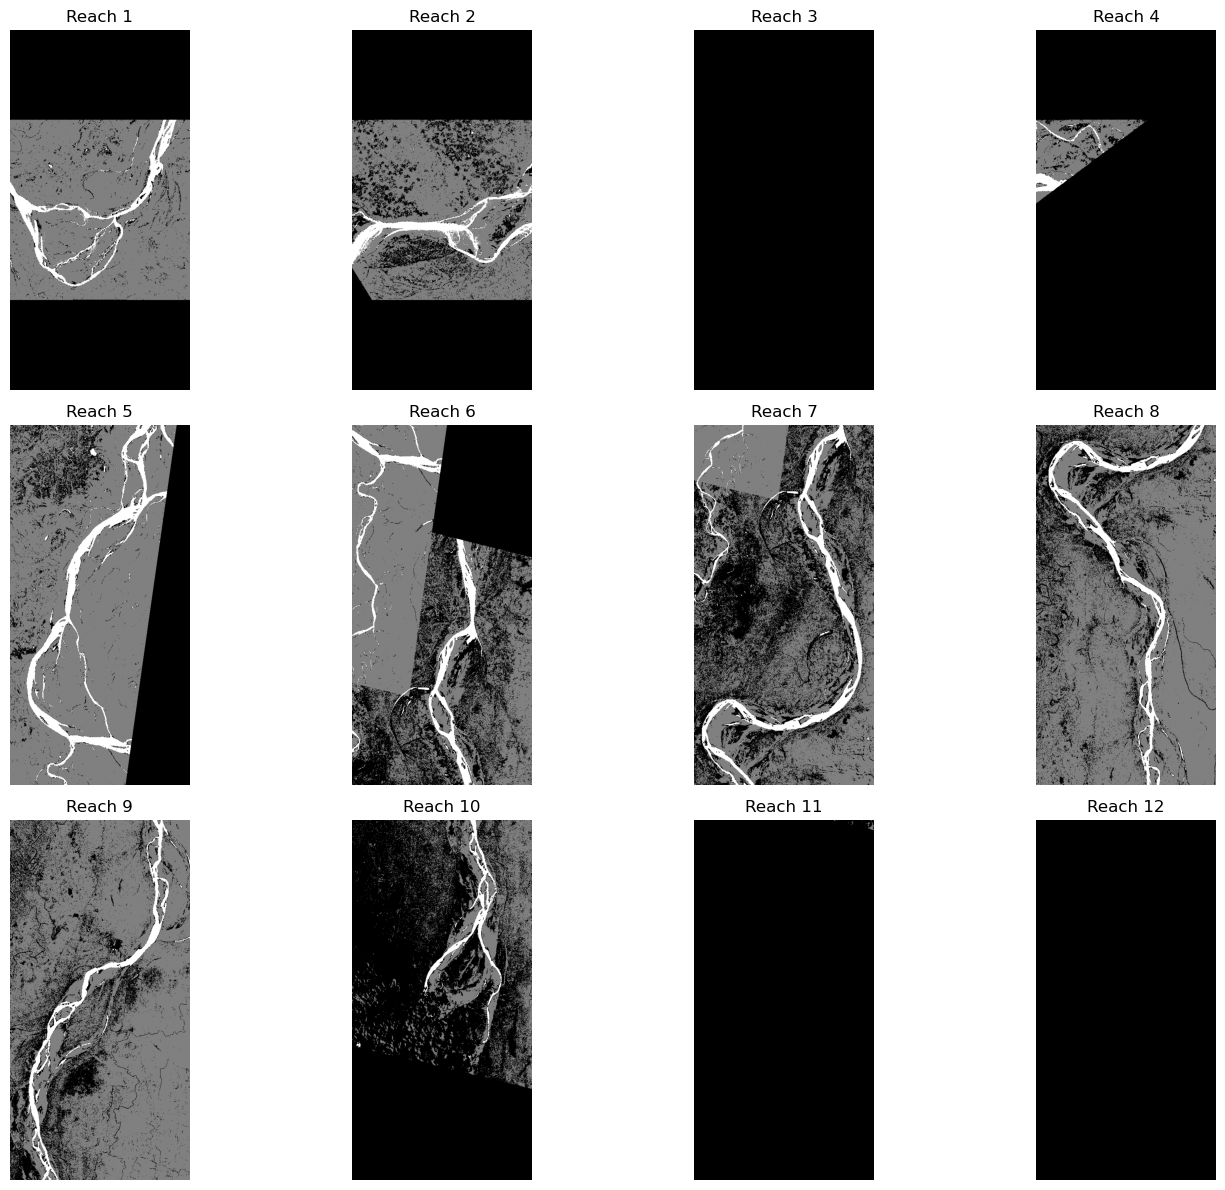

In [45]:
# Select year and month
year = 2000
month = 2

month_dir = os.path.join(directory, f'month_{str(month)}')

# Get list of reach folders (filtering for folders only to be safe)
reach_folders = [f for f in os.listdir(month_dir) if os.path.isdir(os.path.join(month_dir, f))]
num_reaches = len(reach_folders)

# 2. Setup Subplots Grid
# Calculate columns (e.g., 4) and required rows
cols = 4 
rows = math.ceil(num_reaches / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axs = axs.flatten() # Flattens the grid so we can loop over it easily

# 3. Loop over reaches
# We assume reaches are numbered 1 to N. 
# If your folders are not perfectly sequential, consider looping over `reach_folders` directly.
for i in range(num_reaches):
    reach_num = i + 1
    ax = axs[i]
    
    # Construct the dynamic path
    # Folder pattern: ...Ganges_02_r1
    sub_folder_name = f"JRC_GSW1_4Monthlyhistory_Ganges_{month:02d}_r{reach_num}"
    
    # File pattern: ...Ganges_2011-02_r1.tif
    file_name = f"JRC_GSW1_4_Monthlyhistory_Ganges_{year}-{month:02d}_r{reach_num}.tif"
    
    full_path = os.path.join(month_dir, sub_folder_name, file_name)

    # Open and Display
    img_ds = gdal.Open(full_path)

    if img_ds is None:
        # Handle missing files gracefully
        ax.text(0.5, 0.5, f'Reach {reach_num}\nNot Found', 
                ha='center', va='center', color='red')
        ax.set_title(f"Reach {reach_num} (Missing)")
    else:
        # Read and plot
        img_array = img_ds.ReadAsArray()
        ax.imshow(img_array, vmin=vmin, vmax=vmax) # Ensure vmin/vmax are defined
        ax.set_title(f"Reach {reach_num}")

    # Remove axis ticks for cleaner look
    ax.axis('off')

# 4. Cleanup empty subplots (if any)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

### 3. Calculate total amount of pixels for each class 

For each reach a <code>*.csv</code> file is created to store information on total number of pixels for each class.

**<span style="color:red">Attention!</span>**
\
There is no need to run the following cells because all <code>*.csv</code> files are already generated.

**<span style="color:red">Attention 2!</span>**
\
The next cells should be run after all images are preprocessed, in order to make sure these all have the same dimension and orientation.

In [ ]:
# training reaches
reach_id = 0
folders_training = []

for month in os.listdir(directory):
    month_folder = os.path.join(directory, str(month))
    # Check if it's actually a directory to avoid errors
    if os.path.isdir(month_folder):
        for folder in os.listdir(month_folder):
             # Store a tuple: (path_to_month_folder, folder_name)
            folders_training.append((month_folder, folder))

# Sort based on the folder name (the second item in the tuple)
folders_training.sort(key=lambda x: int(x[1].split('_r')[-1]))

# Unpack the tuple here
for month_dir, folder_name in folders_training:
    print(fr'Started counting pixels in folder "{folder_name}"...')
    
    # Use the specific month_dir for this specific folder
    save_tot_pixels(reach_id, directory=month_dir, collection=folder_name) 
    
    reach_id += 1
    print(f'Finished counting pixels folder "{folder_name}"!\n')

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_01_r1"...


c:\Users\mathi\miniconda3\envs\braided\lib\site-packages\osgeo\gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_01_r1"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_02_r1"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_02_r1"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_03_r1"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_03_r1"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_04_r1"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_04_r1"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_01_r2"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_01_r2"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_02_r2"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_02_r2"!

Started counting pixels in folder "JRC_GSW1_4Monthlyhistory_Ganges_03_r2"...
Finished counting pixels folder "JRC_GSW1_4Monthlyhistory_Ganges_03_r2"!

Started counting pix

In [ ]:
# # validation reaches

# reach_id = 0
# # initiate folders list to store folders' name
# folders_validation = []

# for folder in os.listdir(dir_proc):
#     if val in folder: # include only validation reaches
#         folders_validation.append(folder)

# # sort folders based on reach_id
# folders_validation.sort(key=lambda x: int(x.split(f'_{val}_r')[-1]))

# for folder in folders_validation:
#     print(fr'Started counting pixels in folder "{folder}"...')
#     reach_id += 1
#     save_tot_pixels(val, reach_id) # do it for all images
#     print(f'Finished counting pixels folder "{folder}"!\n') 

Started counting pixels in folder "JRC_GSW1_4_MonthlyHistory_validation_r1"...
Finished counting pixels folder "JRC_GSW1_4_MonthlyHistory_validation_r1"!



In [ ]:
# # testing reaches

# reach_id = 0
# # initiate folders list to store folders' name
# folders_testing = []

# for folder in os.listdir(dir_orig):
#     if test in folder: # include only testing reaches
#         folders_testing.append(folder)

# # sort folders based on reach_id
# folders_testing.sort(key=lambda x: int(x.split(f'_{test}_r')[-1]))

# for folder in folders_testing:
#     print(fr'Started counting pixels in folder "{folder}"...')
#     reach_id += 1
#     save_tot_pixels(test, reach_id) # do it for all images
#     print(f'Finished counting pixels folder "{folder}"!\n')

Started counting pixels in folder "JRC_GSW1_4_MonthlyHistory_testing_r1"...
Finished counting pixels folder "JRC_GSW1_4_MonthlyHistory_testing_r1"!



**<span style="color:red">Attention!</span>**
\
The next cells were used to compute the max values present within an image because in some of them it was found that this value was 3 and not 2 as it was expected. This happens only for reshaped images, although it seems not to occur more now it is something to be aware of.

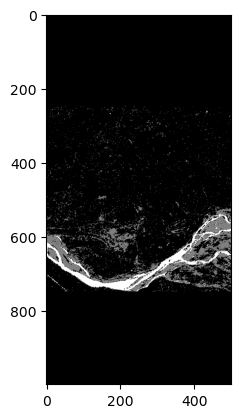

In [14]:
img_90 = gdal.Open(r"data\satellite\Ganges_images\month_1\JRC_GSW1_4Monthlyhistory_Ganges_01_r3\JRC_GSW1_4_Monthlyhistory_Ganges_2011-01_r3.tif")
img_array_90 = img_90.ReadAsArray()
plt.imshow(img_array_90, vmin=vmin, vmax=vmax)

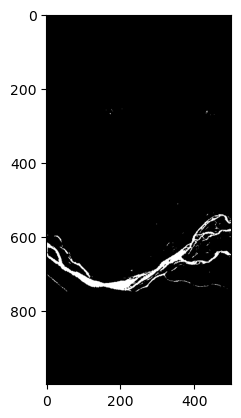

In [15]:
# should show where the max are located but is not working

max_value = np.max(img_array_45)
mask_array = np.where(img_array_45 == max_value, 1, 0)

# Plot the locations of the maximum value
plt.imshow(mask_array, cmap='gray', vmin=0, vmax=1)
plt.show()

### 4. Calculate the "average" image across a season (from January to April of the same year) 

For each reach a <code>*.csv</code> file is created to store the pixel value of the average image across a season. The average is used to replace `no-data` pixels of the imagse used in the datasets, and consequently create only binary images with two classes (`non-water` and `water`). 

**<span style="color:red">Attention!</span>**
\
The next cell was used to compute and save the season average image for al years and reaches by setting the default `window_size=15` and `replace_default=0`. There is no need to rerun the cell, unless different values are to be chosen.

In [25]:
month = os.listdir(directory)[0]
mont_dir = os.path.join(directory, str(month))

n_reaches = os.listdir(month_dir)

print(range(1,len(n_reaches)+1))

range(1, 13)


In [30]:
# loop over all reaches
for use in train:
    # if use == val or use == test:
    #     reach = 1
    #     print(f'Started exporting {use} reach {reach}')
    #     export_good_avg(use, 1)
    #     print(f'Finished exporting {use} reach {reach}\n')
    # else:
    reaches = [i for i in range(1, len(n_reaches)+1)] 
    for reach in reaches:
        print(f'Started exporting {use} reach {reach}')
        export_good_avg(use, reach,dir_datasets=directory)
        print(f'Finished exporting {use} reach {reach}\n')

Started exporting t reach 1
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting t reach 11

Started exporting t reach 12
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting r reach 2

Started exportin

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting r reach 5

Started exporting r reach 6
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting r reach 9

Started exporting r reach 10
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting r reach 10

Started exporting r reach 11
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting a reach 1

Started exporting a reach 2
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting a reach 9

Started exporting a reach 10
Skipping year 1988: No images found (avg

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting a reach 10

Started exporting a reach 11
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 1

Started exporting i reach 2
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 2

Started exporting i reach 3
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 3

Started exporting i reach 4
Skipping year 1988: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 5

Started exporting i reach 6
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 6

Started exporting i reach 7
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 9

Started exporting i reach 10
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 10

Started exporting i reach 11
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 11

Started exporting i reach 12
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 12

Started exporting n reach 1
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 1

Started exporting n reach 2
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 2

Started exporting n reach 3
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 4

Started exporting n reach 5
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 5

Started exporting n reach 6
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 6

Started exporting n reach 7
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 7

Started exporting n reach 8
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 7

Started exporting i reach 8
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting i reach 8

Started exporting i reach 9
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 3

Started exporting n reach 4
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 5

Started exporting n reach 6
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 7

Started exporting n reach 8
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 8

Started exporting n reach 9
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting n reach 10

Started exporting n reach 11
Skipping year 1988: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2021: No images found (avg is scalar).
Finished exporting g reach 1

Started exporting g reach 2
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting g reach 5

Started exporting g reach 6
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting g reach 6

Started exporting g reach 7
Skipping year 1988: No images found (avg is scalar).
Skipping year 1989: No images found (avg is scalar).
Skipping year 1990: No images found (avg is scalar).
Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg 

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1991: No images found (avg is scalar).
Skipping year 1992: No images found (avg is scalar).
Skipping year 1993: No images found (avg is scalar).
Skipping year 1994: No images found (avg is scalar).
Skipping year 1995: No images found (avg is scalar).
Skipping year 1996: No images found (avg is scalar).
Skipping year 1997: No images found (avg is scalar).
Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 1998: No images found (avg is scalar).
Skipping year 1999: No images found (avg is scalar).
Skipping year 2000: No images found (avg is scalar).
Skipping year 2001: No images found (avg is scalar).
Skipping year 2002: No images found (avg is scalar).
Skipping year 2003: No images found (avg is scalar).
Skipping year 2004: No images found (avg is scalar).
Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is sc

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 

Skipping year 2005: No images found (avg is scalar).
Skipping year 2006: No images found (avg is scalar).
Skipping year 2007: No images found (avg is scalar).
Skipping year 2008: No images found (avg is scalar).
Skipping year 2009: No images found (avg is scalar).
Skipping year 2010: No images found (avg is scalar).
Skipping year 2011: No images found (avg is scalar).
Skipping year 2012: No images found (avg is scalar).
Skipping year 2013: No images found (avg is scalar).
Skipping year 2014: No images found (avg is scalar).
Skipping year 2015: No images found (avg is scalar).
Skipping year 2016: No images found (avg is scalar).
Skipping year 2017: No images found (avg is scalar).
Skipping year 2018: No images found (avg is scalar).
Skipping year 2019: No images found (avg is scalar).
Skipping year 2020: No images found (avg is scalar).
Skipping year 2021: No images found (avg is scalar).
Finished exporting g reach 11

Started exporting g reach 12
Skipping year 1988: No images found (av

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = np.nanmean(imgs, axis=0) # compute pixel-wise average excluding NaN
c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided\preprocessing\satellite_analysis_pre.py:501: RuntimeWarning: Mean of empty slice
  avg_season = 